In [16]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
from tqdm.notebook import tqdm
import numpy as np
from einops import rearrange
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, fbeta_score

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
class Dataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        for label, subdir in enumerate(os.listdir(root_dir)):
            subdir_path = os.path.join(root_dir, subdir)
            if os.path.isdir(subdir_path):
                for img_name in os.listdir(subdir_path):
                    img_path = os.path.join(subdir_path, img_name)
                    self.image_paths.append(img_path)
                    self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [4]:
root_dir = 'data/classify'
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
dataset = Dataset(root_dir=root_dir, transform=transform)

In [5]:
batch_size = 16
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [6]:
import torch.nn as nn

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(256 * 64 * 64, 256),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(256, 2)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

In [7]:
model = CNN().to(device)

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)

In [9]:
def train_model(model, data_loader, criterion, optimizer, num_epochs=5):
    for epoch in range(num_epochs):
        with tqdm(data_loader, unit="batch") as tepoch:
            for inputs, labels in tepoch:
                tepoch.set_description(f"Epoch {epoch+1}")
                inputs, labels = inputs.to(device), labels.to(device)
                
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                
                tepoch.set_postfix(loss=loss.item())

    # 모델 저장
    torch.save(model.state_dict(), 'model/model.pth')
    print("model saved.")

In [10]:
train_model(model, data_loader, criterion, optimizer)

  0%|          | 0/63 [00:00<?, ?batch/s]

  0%|          | 0/63 [00:00<?, ?batch/s]

  0%|          | 0/63 [00:00<?, ?batch/s]

  0%|          | 0/63 [00:00<?, ?batch/s]

  0%|          | 0/63 [00:00<?, ?batch/s]

model saved.


In [11]:
model = CNN().to(device)
model.load_state_dict(torch.load('model/model.pth'))
model.eval()

CNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=1048576, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=256, out_features=2, bias=True)
  )
)

In [ ]:
correct = 0
total = 0
all_labels = []
all_predictions = []

with torch.no_grad():
    for inputs, labels in tqdm(data_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

  0%|          | 0/63 [00:00<?, ?it/s]

Accuracy: 98.8%
L2 Score: 0.011999999999999999


Accuracy: 98.8%
F2 Score: 0.9879990323193806


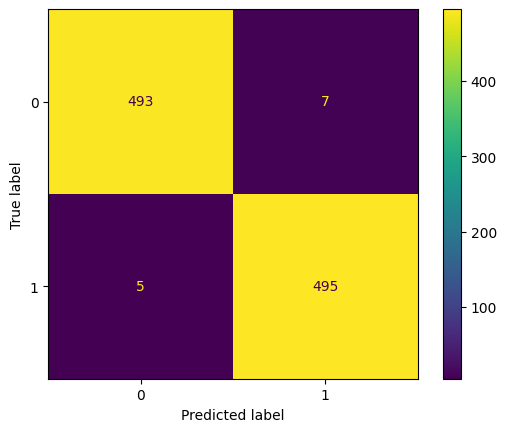

In [17]:
accuracy = 100 * correct / total
f2_score = fbeta_score(all_labels, all_predictions, beta=2, average='weighted')

print(f"Accuracy: {accuracy}%")
print(f"F2 Score: {f2_score}")

cm = confusion_matrix(all_labels, all_predictions)
plt = ConfusionMatrixDisplay(confusion_matrix=cm)
plt.plot()